In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from numpy import median


def line_plot(filename: str, df, x: str, y: list, groups=None):
    def q1(x):
        return x.quantile(0.25)

    def q3(x):
        return x.quantile(0.75)

    vals = dict([(key, [q1, q3, median]) for key in y])

    summary = df.groupby(groups + [x]).agg(vals)
    summary.columns = ["_".join(col).replace("_", "") for col in summary.columns.to_flat_index()]
    summary.reset_index(inplace=True)

    key_df = df.drop_duplicates(subset=groups)

    for i in range(len(key_df)):
        tmp = summary
        current_filename = filename
        for key in groups:
            tmp = tmp[tmp[key] == key_df[key].iloc[i]]
            current_filename += f"_{key_df[key].iloc[i]}"
        tmp.to_csv(f"{current_filename}.txt".replace("_", ""), sep="\t", index=False)


def shorten_file(file, ys):
    df = pd.read_csv(file, sep="\t")
    df["keep"] = True
    for idx in range(len(df) - 1):
        different = False
        for y in ys:
            if df[y].iloc[idx] != df[y].iloc[idx - 1]:
                different = True
                break
        if different:
            df["keep"].iloc[idx - 1] = True
        else:
            df["keep"].iloc[idx] = False
    ddf = df[df["keep"] == True]
    ddf.to_csv(file.replace(".txt", "s.txt"), index=False, sep="\t")

In [11]:
op_df = pd.read_csv("data/operations.csv")
op_df.head()

,ave_fitness,ave_genome_length,ave_tree_depth,ave_tree_nodes,ave_used_codons,best_fitness,gen,invalids,max_genome_length,max_tree_depth,...,runtime_error,time_adjust,time_taken,total_inds,total_time,Unnamed: 21,seed,n,p,problem
0,1.562467,36.526,7.480000,35.831000,24.541000,0.5,0,0,147,10.0,...,0,0,1.231026,1000,1.231026,NaN,0,2,1,add
1,1.531813,34.445,7.957534,29.968493,20.527397,0.5,1,270,180,17.0,...,0,0,0.228045,2000,1.459071,NaN,0,2,1,add
2,1.476986,36.227,7.843862,28.617402,19.607867,0.5,2,431,146,17.0,...,0,0,0.143364,3000,1.602435,NaN,0,2,1,add
3,1.477410,37.921,7.772622,27.544084,18.873550,0.5,3,569,146,17.0,...,0,0,0.144507,4000,1.746942,NaN,0,2,1,add
4,1.466457,39.796,7.693002,26.433409,18.116253,0.5,4,683,151,14.0,...,0,0,0.160311,5000,1.907253,NaN,0,2,1,add


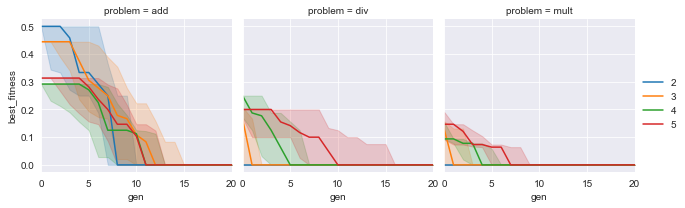

In [4]:
g = sns.FacetGrid(op_df, col="problem")
g.map_dataframe(sns.lineplot, x="gen", y="best_fitness", hue="n", estimator="median", errorbar=("pi", 50))
g.set(xlim=(0, 20))
g.add_legend()
plt.show()

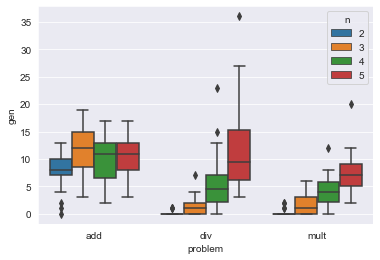

In [5]:
zero_fit_op_df = op_df[op_df["best_fitness"] == 0].groupby(["problem", "seed", "n", "p"])["gen"].min().reset_index()
sns.boxplot(zero_fit_op_df, x="problem", y="gen", hue="n")
plt.show()

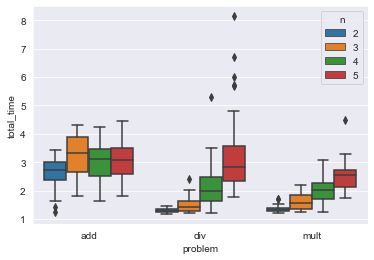

In [6]:
zero_fit_op_time = op_df[op_df["best_fitness"] == 0].groupby(["problem", "seed", "n", "p"])[
    "total_time"].min().reset_index()
sns.boxplot(zero_fit_op_time, x="problem", y="total_time", hue="n")
plt.show()

In [7]:
line_plot("results/pgfplots/lp", op_df, "gen", ["best_fitness"], groups=["problem", "n"])
for p in ["add", "div", "mult"]:
    for n in range(2, 6):
        f = f"results/pgfplots/lp{p}{n}.txt"
        shorten_file(f, ["bestfitnessmedian", "bestfitnessq1", "bestfitnessq3"])

C:\Users\giorg\AppData\Local\Temp/ipykernel_7808/654610735.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["keep"].iloc[idx - 1] = True
C:\Users\giorg\AppData\Local\Temp/ipykernel_7808/654610735.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["keep"].iloc[idx] = False
C:\Users\giorg\AppData\Local\Temp/ipykernel_7808/654610735.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["keep"].iloc[idx - 1] = True
C:\Users\g

In [8]:
df_wide = pd.pivot(zero_fit_op_df, index=["problem", "seed"], columns="n", values="gen").reset_index()
for p in df_wide["problem"].unique():
    temp = df_wide[df_wide["problem"] == p]
    temp.to_csv(f"results/pgfplots/bp{p}.txt", sep="\t", index=False)

In [9]:
df_wide = pd.pivot(zero_fit_op_time, index=["problem", "seed"], columns="n", values="total_time").reset_index()
for p in df_wide["problem"].unique():
    temp = df_wide[df_wide["problem"] == p]
    temp.to_csv(f"results/pgfplots/time{p}.txt", sep="\t", index=False)